In [1]:
import collections
import math
import os
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)


def read_data(filename):
    ''' zip 파일에 포함된 텍스트 파일을 읽어서 단어 리스트 생성. 포함된 파일은 1개. 
    zip 파일은 30mb, txt 파일은 100mb. '''
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split()                 # 갯수 : 17005207


vocabulary = read_data(filename)
print('Data size', len(vocabulary))   

# .을 기준으로 리스트 여러개로 나눈후에 space로 다시 리스트로 나눈다.
# I like you. you like me -> [[I like you], [you like me]] -> [[[I] [like] [you]], ... ]

Found and verified text8.zip
Data size 17005207


In [3]:
def word_numbering(vocabulary, number_of_n_words=50000):
    """
    Arguments:
    vocabulary -- a list of words you want to train the word2vec
    number_of_n_words -- number of most frequent n words in the vocabulary you want to set
    
    Returns:
    int_voc -- a list of vocabulary that is mapped into integer-valeud index
    word_to_int -- python dict mapping words in the vocabulary into an integer-valued index
    int_to_word -- python dict mapping integer-valued index to words
    most_frequent_n_words -- a list with pairs of n most frequent words with its frequency -> [(word, frequency)]
    """
    word_count = collections.Counter(vocabulary)
    most_frequent_n_words = word_count.most_common(number_of_n_words - 1)
            
    word_to_int = {'UNK': 0} # set 0 as unknown token
    for word, _ in most_frequent_n_words:
        word_to_int[word] = len(word_to_int)
    
    int_to_word = {v: k for k, v in word_to_int.items()} # reverse dict of word_to_int


    count = 0
    int_voc = []

    for word in vocabulary:
        if word in word_to_int: # if word is in n most frequent words
            int_voc.append(word_to_int[word]) #. change the word into the corresponding integer
        else:
            int_voc.append(0) # not in the n most frequent word.
            count += 1   # number of words that are not in n most frequent words
 
    most_frequent_n_words.insert(0, ('UNK', count))
    #most_frequent_n_words = np.insert(most_frequent_n_words, 0,('UNK', count),axis=0)
            
    return int_voc, list(word_to_int.keys()), most_frequent_n_words
    
# del vocabulary

In [4]:
data, ordered_words, most_frequent_n_words = word_numbering(vocabulary)

In [5]:
def compute_f(most_frequent_n_words):
    """
    Computing the portion of each word from most_frequent_n_words
    parameter passing이 문제가 될시 most_frequent_n_words를 passing 하지않고 사용할 수도 있을 것 같다.
    Arguments:
    most_frequent_n_words -- a list of most frequent words, length of "vocabulary_size" 
                             with tuple [(word, word_frquency), ...]
    
    Returns:
    divided_frequency -- a numpy array containing the word_frequency in descending order, size of (vocabulary_size, )
    """
    list_to_numpy = np.array(most_frequent_n_words)
    divided_words = list_to_numpy[:, 0]
    divided_frequency = list_to_numpy[:, 1].astype(np.int)
    sum_frquency = np.sum(divided_frequency)
    assert ( sum_frquency.shape == ())
    divided_frequency = divided_frequency / sum_frquency
    
    
    
    return divided_frequency

In [6]:
divided_frequency = compute_f(most_frequent_n_words) # 필요한 코드 지우지말자

In [7]:
def subsampling(divided_frequency,  t=0.00001):
    """
    Arguments:
    divided_frequency -- a numpy array of the frequency of each word, shape of (vocabulary_size,)
    t -- threshold 
    
    Returns:
    p_w -- a numpy array of probability of dropping each word, shape of (vocabulary_size, )
    """
    p_w = (divided_frequency - t )/divided_frequency - np.sqrt(t / divided_frequency)
    p_w[p_w < 0] = 0
    assert (p_w.shape == divided_frequency.shape)
    
    return p_w

In [8]:
def noise_distribution(divided_frequency):
    """
    Used in negative sampling, the probabiltiy of choosing n negative samples
    Arguments:
    divided_frequency -- a numpy array of the frequency of each word, shape of (vocabulary_size,)

    Returns:
    neg_p_w: a numpy array of probability of each words in most_frequent_n_words, shape of (vocabulary_size, )
    """
    f = np.power(divided_frequency, 0.75)
    neg_p_w = f/ sum(f)
    return neg_p_w

In [9]:
divided_frequency

array([  2.46036993e-02,   6.24159412e-02,   3.49114833e-02, ...,
         5.29249659e-07,   5.29249659e-07,   5.29249659e-07])

In [10]:
noise = (noise_distribution(divided_frequency)) # 필요한 코드 지우지말자 

In [11]:
def create_mini_batch(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  a numpy array ofthe index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    context_index = np.random.choice(num_range)
    
    for i in range(batch_size): # may need change
        batch[i] = data[data_index]
        labels[i] = data[context_index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [22]:
batch, labels, data_index = create_mini_batch(data, batch_size=1, window_size=3, data_index=0, sentence_index=0)
print(data_index)
for i in range(1):
    print('{} {} -> {} {}'.format(batch[i],     ordered_words[batch[i]],
                                  labels[i], ordered_words[labels[i]]))

1
5234 anarchism -> 3081 originated


In [13]:
def parameter_initialization(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    parameters -- a python dictionary containing weights 
                         -- W_in, size of (vocabulary_size, projection_size)
                         -- W_out, size of (projection_size, vocabulary_size)
    """
    
    np.random.seed(0)
    parameters = {}
    
    parameters['W_in'] = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 
    
    parameters['W_out'] = np.random.randn(projection_size, vocabulary_size) *  np.sqrt(2 / projection_size)
    
    assert (parameters['W_in'].shape == (vocabulary_size, projection_size)) 
    assert (parameters['W_out'].shape == (projection_size, vocabulary_size))
    
        
    return parameters

In [14]:
def sigmoid(z):
    """
    sigmoid function
    
    Arguments:
    Z -- a numpy array of any shape
    
    Returns:
    sig -- a numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [15]:
def compute_cost(batch, labels, parameters, is_pos):
    """
    Arguments:
    batch -- the index of the target word 
    labels -- the indexes of the context words
    parameters -- a python dictionrary containing W_in and W_out, used to calcuate the part of cost function
    is_pos -- if "pos", compute np.multiply(out, hidden), if "neg" compute -np.multiply(out, hidden)
    
    Returns:
    cost -- a partial cost for feed_forward_NN
    """
    assert(batch.shape==labels.shape)
    W_in = parameters["W_in"]
    W_out = parameters["W_out"]
    
    hidden = W_in.T[:,batch]
    out = W_out[:, labels]
    if is_pos == "pos":
        cost = np.sum(np.multiply(out, hidden),axis=0)
    elif is_pos == "neg":
        cost = - np.sum(np.multiply(out, hidden),axis=0)
    cost = sigmoid(cost)
    cost = -np.log(cost)
    
    assert (hidden.shape == (W_in.shape[1], len(batch)))
    assert (out.shape == (W_in.shape[1], len(batch)))
    assert (cost.shape == (len(batch),))
    
    return cost

In [16]:
def feed_forward_NN(batch, labels, k, parameters):
    """    
    Compute the cost function for Word2vec and returns the cost and the index of negative samples
    
    Arguments:
    batch-- a numpy array contaring the input of Neural Network of shape (batch_size, ) size = 1 로 가정하자
    labels -- a numpy array containing the true labeled output of shape (batch_size, )
    k -- number of negative sampling
    parameters -- python dictionary containing weights W_in, W_out
    
    Returns:
    cost -- the cost function of the NN
    negs -- a numpy array containing the indexes of negative samples
    """
    positive = compute_cost(batch, labels, parameters, "pos")
    for i, label_word in enumerate(batch):
        # This will be replaced with the noise distriution Pn(W)
            
        negative_samples = np.random.choice(np.arange(0,50000), k, p=noise) # changed to noise distribution 
        neg_batch = np.array([label_word for _ in range (k)])
        negs = negative_samples # batch size가 바뀌면 수정되야하는 부분
        
        assert (negative_samples.shape == neg_batch.shape)
        
        neg = np.sum(compute_cost(neg_batch, negative_samples, parameters, "neg"))
        positive[i] = positive[i] + neg 
        
    cost = np.mean(positive)
    assert(cost.shape == ())
    return cost, negs

# negative sampling 도 return 해야 할것 같다? ?


In [17]:
def backpropagation(batch, labels, negs, parameters, learning_rate=0.01):
    """
    calculates the backpropagation and updates the parameters 
    
    Arguments:
    batch -- a numpy array containing the index of the batch
    labels -- a numpy array containing the index of the label
    negs -- a numpy array containng the indexes of negative samples 
    parameters -- a python dictonary containing numpy array parameters that are needed to be updated.
                   -- W_in, shape of (vocabulary_size, projection_size) 
                   -- W_out, shape of (projection_size, vocabulary_size)
    learning rate -- an integer, learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containing updated parameters containing W_in and W_out
    """
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    hidden = W_in.T[:, batch] # shape: (100, 1)
    
    out = W_out[:, labels] # shape: (100,1)
    neg_out = W_out[:, negs] # shape: (100, k)
    
    k = len(negs)
    
    out_sig = sigmoid(np.sum(np.multiply(out, hidden),axis=0)) - 1
    out_neg_sig = sigmoid(np.sum(np.multiply(neg_out, hidden),axis=0, keepdims=True)) # (1,100) 여기 뭔가 문제있는데?
    
    assert(out_neg_sig.shape == (1, k))
    s = np.sum(out_neg_sig * neg_out, axis=1, keepdims=True)
    t = np.multiply(out_sig, out)
    assert(s.shape==t.shape)
    grads_in = s+t
    
    grads_out = (out_sig) * hidden  # hidden (100, 1)
    grads_neg_out = (out_neg_sig) *  hidden
            
    # update should be done at the same time 
    W_in[batch,:] = W_in[batch,:] - learning_rate * grads_in.T
    W_out[:, labels] = W_out[:, labels] - learning_rate * grads_out
    W_out[:, negs] = W_out[:, negs] - learning_rate * grads_neg_out
    
    return parameters

In [18]:
def train(vocabulary, projection_size, vocabulary_size, epoch, training_time, learning_rate):
    """
    Arguments:
    vocabularary -- a list of data set
    projection_size -- the projection size of a neural network
    vocabulary_size -- used to limit the size of vocabulary 
    epoch -- number of epoches in training the network
    training time -- number of iterations in each epoch -- 구현이 끝나면 빼야한다.
    learning rate -- learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containg trained parameters W_in and W_out
    """
    parameters = parameter_initialization(vocabulary_size, projection_size)
    
  #  data, ordered_words, most_frequent_n_words = word_numbering(vocabulary, vocabulary_size)

    for j in range(epoch):
        data_index = 0
        
        for i in range(training_time):
            batch, labels, data_index = create_mini_batch(data, batch_size=1, window_size=3, data_index=data_index,
                                                          sentence_index=0)
            cost, negs = feed_forward_NN(batch,labels, 20, parameters)
            # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
            parameters = backpropagation(batch, labels, negs, parameters, learning_rate)

            if i % 1000000 == 0:
                print("The cost at:", i,"th iteration is",cost)

    return parameters

In [26]:
parameters=train(vocabulary, 300, 50000, 1, 1000000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is 14.532962223
The cost at: 1000000 th iteration is 5.76393485519
The cost at: 2000000 th iteration is 2.98237175843
The cost at: 3000000 th iteration is 0.865450175073
The cost at: 4000000 th iteration is 5.4519366114
The cost at: 5000000 th iteration is 4.23380880487
The cost at: 6000000 th iteration is 3.47074348484
The cost at: 7000000 th iteration is 4.54649290677
The cost at: 8000000 th iteration is 0.575478034133
The cost at: 9000000 th iteration is 2.40761529522
The cost at: 10000000 th iteration is 2.54031889636
The cost at: 11000000 th iteration is 3.22661280975
The cost at: 12000000 th iteration is 4.20263881934
The cost at: 13000000 th iteration is 4.3529601316
The cost at: 14000000 th iteration is 2.54972330493
The cost at: 15000000 th iteration is 1.59263775585
The cost at: 16000000 th iteration is 5.06807146445
The cost at: 0 th iteration is 4.67868465723
The cost at: 1000000 th iteration is 2.56758401412
The cost at: 2000000 th iteration is 

In [29]:
final_embeddings = parameters['W_in']

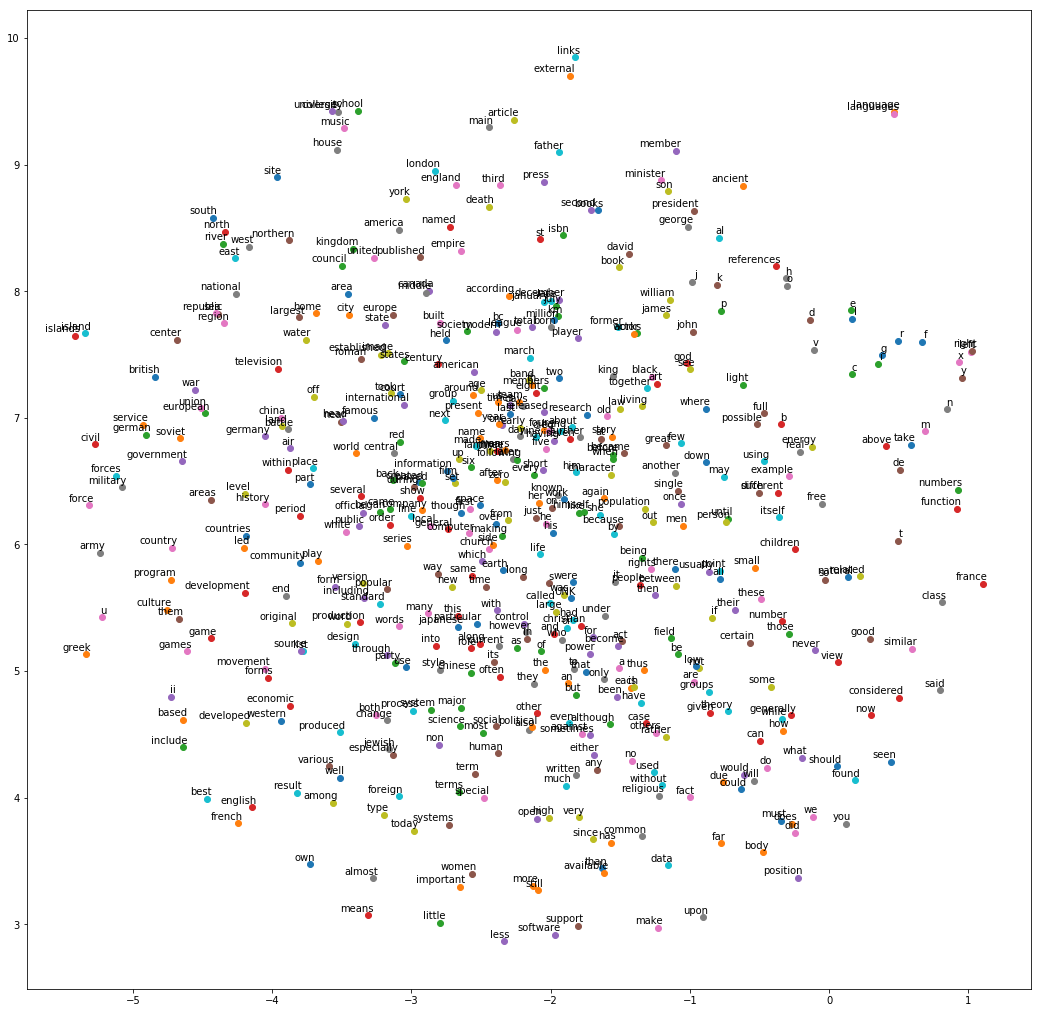

In [30]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')


In [ ]:
final_embeddings

In [ ]:
def feed_forward_softmax():